In [3]:
# === Silhouette Comparison from 3D Points (2 states) ===
# Inputs: two CSVs with columns ['middle_x','middle_y','middle_z']
# Outputs: overlays per view (PNG) + metrics.csv
# Views: orthographic along X/Y/Z of the **aligned shared frame**

import os, json, numpy as np, pandas as pd
from dataclasses import dataclass
from typing import Tuple
from scipy.ndimage import gaussian_filter, label, binary_closing
from scipy.spatial import cKDTree
from skimage.measure import find_contours
import matplotlib.pyplot as plt

# Config
@dataclass
class SilhouetteCfg:
    grid_base: int = 160
    pad_frac: float = 0.05
    sigma_vox: float = 3.0
    thr_quantile: float = 0.90
    min_blob_vox: int = 200
    post_close: int = 2
    out_dir: str = "out_silhouette_2state"
    trim_q: float = 0.10      # ICP trimming (top-q distances dropped)
    icp_iters: int = 30
    sample_icp: int = 50000   # max points used in ICP

# IO
def load_points(csv):
    df = pd.read_csv(csv)
    P = df[["middle_x","middle_y","middle_z"]].dropna().values.astype(np.float32)
    if len(P) < 20: raise ValueError(f"Too few points in {csv}")
    return P

#  Alignment utils
def pca_axes(pts: np.ndarray):
    C = np.cov((pts - pts.mean(0)).T)
    w, V = np.linalg.eigh(C)
    V = V[:, np.argsort(w)[::-1]]          # columns are PC1, PC2, PC3
    if np.linalg.det(V) < 0:               # enforce right-handed
        V[:, -1] *= -1
    return V

def nn_metrics(A_pts, B_pts):
    ta, tb = cKDTree(A_pts), cKDTree(B_pts)
    dBA,_ = ta.query(B_pts, k=1)
    dAB,_ = tb.query(A_pts, k=1)
    rmse = float(np.sqrt((np.concatenate([dBA, dAB])**2).mean()))
    haus = float(max(dBA.max(), dAB.max()))
    return rmse, haus

def best_pca_prealign(B_pts, A_pts):
    # search all 3! perms × 2^3 sign flips to map B's PCA to A's PCA
    import itertools
    Va, Vb = pca_axes(A_pts), pca_axes(B_pts)
    perms = list(itertools.permutations(range(3)))
    signs = list(itertools.product([1, -1], repeat=3))
    best_R, best_rmse = np.eye(3), np.inf
    for p in perms:
        P = np.zeros((3,3)); P[range(3), list(p)] = 1
        for s in signs:
            S = np.diag(s)
            R = Va @ (P @ S) @ Vb.T
            rmse, _ = nn_metrics(A_pts, B_pts @ R.T)
            if rmse < best_rmse:
                best_rmse, best_R = rmse, R
    return best_R, best_rmse

def kabsch(P, Q):
    Pc, Qc = P.mean(0), Q.mean(0)
    P0, Q0 = P - Pc, Q - Qc
    H = Q0.T @ P0
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = Pc - Qc @ R.T
    return R, t

def icp_rigid_robust(A_pts, B_pts, iters=30, sample=50000, trim_q=0.10, seed=11):
    rs = np.random.default_rng(seed)
    A = A_pts if len(A_pts) <= sample else A_pts[rs.choice(len(A_pts), sample, replace=False)]
    B = B_pts if len(B_pts) <= sample else B_pts[rs.choice(len(B_pts), sample, replace=False)]
    R, t = np.eye(3), np.zeros(3)
    for _ in range(iters):
        Bx = B @ R.T + t
        tree = cKDTree(A); d, idx = tree.query(Bx, k=1)
        P = A[idx]
        if 0.0 < trim_q < 0.5:
            thr = np.quantile(d, 1 - trim_q)
            keep = d <= thr
            P, Bx = P[keep], Bx[keep]
        R_upd, t_upd = kabsch(P, Bx)
        R = R_upd @ R
        t = (t @ R_upd.T) + t_upd
    return R, t

# Grid & metaball mask 
def make_grid_from_bounds(P: np.ndarray, base=160, pad_frac=0.05):
    mn, mx = P.min(0), P.max(0); ext = mx - mn
    pad = pad_frac * float(ext.max()); mn -= pad; mx += pad; ext = mx - mn
    scale = base / float(ext.max() + 1e-8)
    dims = np.clip(np.ceil(ext * scale).astype(int), 32, 512)
    edges = [np.linspace(mn[i], mx[i], dims[i] + 1, dtype=np.float32) for i in range(3)]
    vx, vy, vz = np.diff(edges[0])[0], np.diff(edges[1])[0], np.diff(edges[2])[0]
    return edges, (vx, vy, vz), dims

def metaball_mask(P: np.ndarray, edges, sigma_vox=3.0, q=0.90, min_blob_vox=200):
    H, _ = np.histogramdd(P, bins=edges); H = H.astype(np.float32)
    F = gaussian_filter(H, sigma=(sigma_vox, sigma_vox, sigma_vox), mode="constant")
    vals = F[F > 0]
    if vals.size == 0: return None
    thr = float(np.quantile(vals, q))
    M = F >= thr
    lbl, nlab = label(M)
    if nlab > 0:
        sizes = np.bincount(lbl.ravel())
        keep = np.where((np.arange(len(sizes)) > 0) & (sizes >= max(1, int(min_blob_vox))))[0]
        M = np.isin(lbl, keep)
    # to (Z,Y,X)
    return np.transpose(M, (2,1,0))

# 2D silhouettes per orthographic view 
def orthographic_mask_2d(M_zyx: np.ndarray, axis: str, post_close=2):
    if axis == 'z':
        S = M_zyx.max(axis=0)   # [y,x]
    elif axis == 'y':
        S = M_zyx.max(axis=1)   # [z,x]
    elif axis == 'x':
        S = M_zyx.max(axis=2)   # [z,y]
    else:
        raise ValueError("axis must be 'x','y','z'")
    S = S.astype(bool)
    if post_close > 0:
        from scipy.ndimage import generate_binary_structure
        st = generate_binary_structure(2, 1)
        for _ in range(post_close):
            S = binary_closing(S, structure=st)
    return S

def extract_main_contour(S2d: np.ndarray):
    cs = find_contours(S2d.astype(float), level=0.5)
    if not cs: return None
    cs.sort(key=lambda c: c.shape[0], reverse=True)
    return cs[0]

# Metrics 
def iou(SA: np.ndarray, SB: np.ndarray) -> float:
    inter = np.logical_and(SA, SB).sum()
    union = np.logical_or(SA, SB).sum()
    return float(inter) / float(union + 1e-9)

def contour_distances(CA: np.ndarray, CB: np.ndarray) -> Tuple[float,float]:
    if CA is None or CB is None: return float('nan'), float('nan')
    TA, TB = cKDTree(CA), cKDTree(CB)
    da,_ = TA.query(CB, k=1); db,_ = TB.query(CA, k=1)
    mean_nn = float((da.mean() + db.mean()) / 2.0)
    haus = float(max(da.max(), db.max()))
    return mean_nn, haus

# Plot overlays 
def save_overlay(SA, SB, CA, CB, title, out_png):
    plt.figure(figsize=(5,5))
    U = np.logical_or(SA, SB)
    plt.imshow(U, cmap="gray", interpolation="nearest", alpha=0.15)
    if CA is not None: plt.plot(CA[:,1], CA[:,0], '-', lw=2.0, label='A', alpha=0.95)
    if CB is not None: plt.plot(CB[:,1], CB[:,0], '-', lw=2.0, label='B', alpha=0.95)
    plt.gca().invert_yaxis(); plt.axis('off'); plt.title(title)
    plt.legend(frameon=False)
    os.makedirs(os.path.dirname(out_png), exist_ok=True)
    plt.tight_layout(); plt.savefig(out_png, dpi=200); plt.close()

# Main
def run_two_state_silhouettes(csv_A: str, csv_B: str, cfg=SilhouetteCfg()):
    # 1) Load points
    A_raw = load_points(csv_A)
    B_raw = load_points(csv_B)

    # 2) Center both
    A0 = A_raw - A_raw.mean(0)
    B0 = B_raw - B_raw.mean(0)

    # 3) Best-PCA perm/sign prealign + robust ICP (align B -> A)
    R_pre, _ = best_pca_prealign(B0, A0)
    B1 = B0 @ R_pre.T
    R_icp, t_icp = icp_rigid_robust(A0, B1, iters=cfg.icp_iters, sample=cfg.sample_icp, trim_q=cfg.trim_q)
    B_aligned = B1 @ R_icp.T + t_icp
    A_aligned = A0.copy()

    # 4) Optional uniform scaling (shared bbox) for fair silhouettes
    mins = np.vstack([A_aligned, B_aligned]).min(0)
    maxs = np.vstack([A_aligned, B_aligned]).max(0)
    s = float((maxs - mins).max())
    A = A_aligned / s; B = B_aligned / s

    # 5) Build shared grid from both; create 3D masks
    edges, _, _ = make_grid_from_bounds(np.vstack([A, B]), base=cfg.grid_base, pad_frac=cfg.pad_frac)
    MA = metaball_mask(A, edges, sigma_vox=cfg.sigma_vox, q=cfg.thr_quantile, min_blob_vox=cfg.min_blob_vox)
    MB = metaball_mask(B, edges, sigma_vox=cfg.sigma_vox, q=cfg.thr_quantile, min_blob_vox=cfg.min_blob_vox)
    if MA is None or MB is None:
        raise RuntimeError("Empty mask for one of the states; tweak sigma/quantile/min_blob_vox.")

    # 6) Silhouettes for X/Y/Z views in the aligned frame
    results = []
    for axis, tag in [('x','+PC1'), ('y','+PC2'), ('z','+PC3')]:
        SA = orthographic_mask_2d(MA, axis, post_close=cfg.post_close)
        SB = orthographic_mask_2d(MB, axis, post_close=cfg.post_close)
        CA = extract_main_contour(SA); CB = extract_main_contour(SB)
        m_iou = iou(SA, SB)
        m_mnn, m_haus = contour_distances(CA, CB)
        out_png = os.path.join(cfg.out_dir, f"overlay_{axis}.png")
        title = f"Silhouette overlay {tag}  (IoU={m_iou:.3f},  mNN={m_mnn:.2f},  H={m_haus:.2f})"
        save_overlay(SA, SB, CA, CB, title, out_png)
        results.append(dict(view=tag, axis=axis, IoU=m_iou, meanNN=m_mnn, Hausdorff=m_haus))

    # 7) Save metrics + provenance
    os.makedirs(cfg.out_dir, exist_ok=True)
    pd.DataFrame(results).to_csv(os.path.join(cfg.out_dir, "metrics.csv"), index=False)
    with open(os.path.join(cfg.out_dir, "meta.json"), "w") as f:
        json.dump(dict(csv_A=csv_A, csv_B=csv_B, cfg=cfg.__dict__,
                       note="Alignment = best-PCA perm/sign + robust ICP; silhouettes from voxelized masks."),
                  f, indent=2)
    print(pd.DataFrame(results))
    print(f"Saved overlays to {cfg.out_dir}/overlay_[x|y|z].png and metrics.csv")

# run 
if __name__ == "__main__":
    CSV_A = "data/green_monkey/all_structure_files/chr1/12hrs/untr/structure_12hrs_untr_gene_info.csv"
    CSV_B = "data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv"
    run_two_state_silhouettes(CSV_A, CSV_B, SilhouetteCfg(
        grid_base=160, pad_frac=0.05, sigma_vox=3.0, thr_quantile=0.90,
        min_blob_vox=200, post_close=2, out_dir="data/green_monkey/va_testing/out_chr1_12h_vacv_vs_untr",
        trim_q=0.10, icp_iters=30, sample_icp=50000
    ))


   view axis       IoU    meanNN  Hausdorff
0  +PC1    x  0.586782  5.414128  23.086793
1  +PC2    y  0.465102  7.617125  28.635642
2  +PC3    z  0.540641  7.590445  24.186773
Saved overlays to data/green_monkey/va_testing/out_chr1_12h_vacv_vs_untr/overlay_[x|y|z].png and metrics.csv


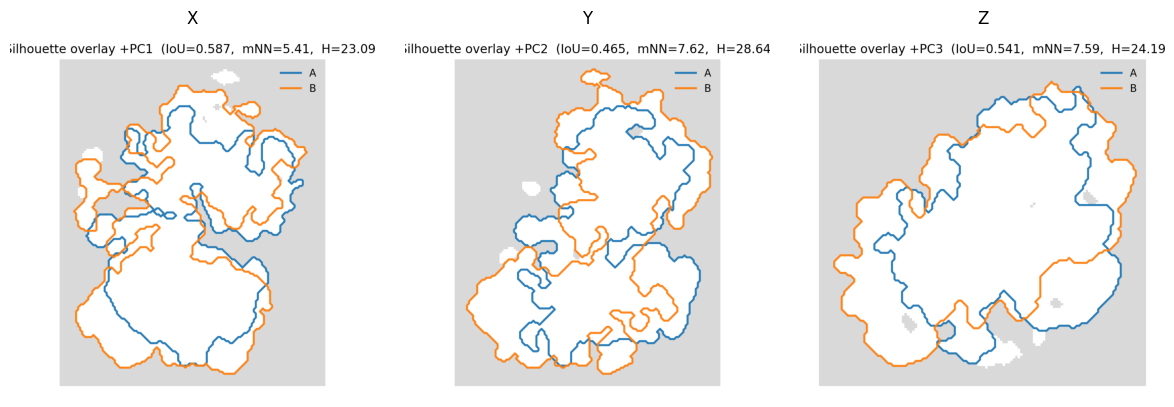

   view axis       IoU    meanNN  Hausdorff
0  +PC1    x  0.586782  5.414128  23.086793
1  +PC2    y  0.465102  7.617125  28.635642
2  +PC3    z  0.540641  7.590445  24.186773


In [4]:
import os, pandas as pd, matplotlib.pyplot as plt, matplotlib.image as mpimg

OUT = "data/green_monkey/va_testing/out_chr1_12h_vacv_vs_untr"  # your out_dir
fig, axs = plt.subplots(1,3, figsize=(12,4))
for ax, axis in zip(axs, ["x","y","z"]):
    img = mpimg.imread(os.path.join(OUT, f"overlay_{axis}.png"))
    ax.imshow(img); ax.set_axis_off(); ax.set_title(axis.upper())
plt.tight_layout(); plt.show()

print(pd.read_csv(os.path.join(OUT, "metrics.csv")))
